In [1]:
import pandas as pd

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# text preprocess
import re
import nltk
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
from nltk.corpus import stopwords

# vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# model
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv('labelled_all.csv',index_col = 0)
data.head(1)

,userName,date,content,score,if_apple,if_useful,mechanism,ad,money,UI/UX,event,keyboard,IP,time/life,customer service,crush,data,system upgrad,connection,other-tech
0,Cre8tiv99,2019-03-11 17:34:05,"Hey guys, this is Bryce “Cre8tiv” Demby. Love ...",3,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df_mech = data[['content','if_apple','if_useful','mechanism']]
df_ad = data[['content','if_apple','if_useful','ad']]

In [4]:
df_mech[['if_apple','if_useful','mechanism']] = df_mech[['if_apple','if_useful','mechanism']].astype('int')
df_ad[['if_apple','if_useful','ad']] = df_ad[['if_apple','if_useful','ad']].astype('int')

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [5]:
# correct dataframe
df_mech.loc[9763,'mechanism'] = -1

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


## EDA

In [7]:
# number of word count in reviews
df_mech['word_count'] = df_mech['content'].apply(lambda x: len(str(x).split()))
print(df_mech[df_mech['mechanism']==1]['word_count'].mean()) # Postive mechanism
print(df_mech[df_mech['mechanism']==0]['word_count'].mean()) # Neutral mechanism
print(df_mech[df_mech['mechanism']==-1]['word_count'].mean()) # Negative mechansim

28.353448275862068
15.799444187123669
44.39221556886228


/var/folders/7c/8ptk959x0m533j_8q9d72vn00000gn/T/ipykernel_8823/788279598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mech['word_count'] = df_mech['content'].apply(lambda x: len(str(x).split()))


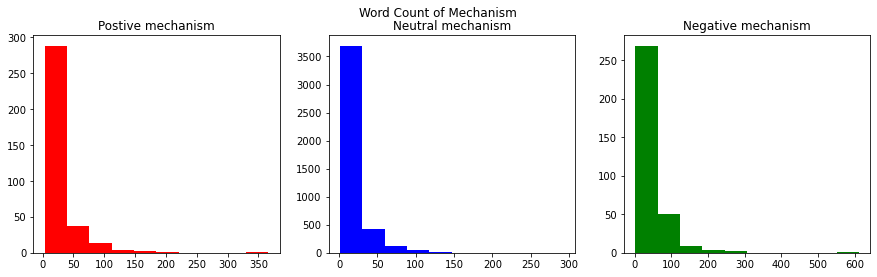

In [8]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,4))
train_words=df_mech[df_mech['mechanism']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Postive mechanism')
train_words=df_mech[df_mech['mechanism']==0]['word_count']
ax2.hist(train_words,color='blue')
ax2.set_title('Neutral mechanism')
train_words=df_mech[df_mech['mechanism']==-1]['word_count']
ax3.hist(train_words,color='green')
ax3.set_title('Negative mechanism')
fig.suptitle('Word Count of Mechanism')
plt.show()

In [9]:
df_ad['word_count'] = df_ad['content'].apply(lambda x: len(str(x).split()))
print(df_ad[df_ad['ad']==1]['word_count'].mean()) # Postive mechanism
print(df_ad[df_ad['ad']==0]['word_count'].mean()) # Neutral mechanism
print(df_ad[df_ad['ad']==-1]['word_count'].mean()) # Negative mechansim

53.55555555555556
18.061398176291792
63.96551724137931


/var/folders/7c/8ptk959x0m533j_8q9d72vn00000gn/T/ipykernel_8823/2091105536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ad['word_count'] = df_ad['content'].apply(lambda x: len(str(x).split()))


Negative reviews always have more word count.

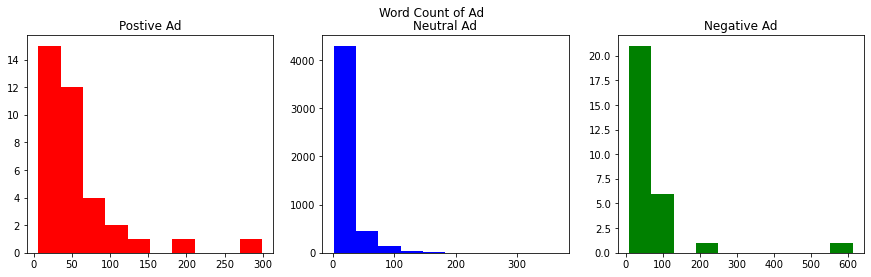

In [10]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,4))
train_words= df_ad[df_ad['ad']== 1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Postive Ad')
train_words=df_ad[df_ad['ad']== 0]['word_count']
ax2.hist(train_words,color='blue')
ax2.set_title('Neutral Ad')
train_words=df_ad[df_ad['ad']== -1]['word_count']
ax3.hist(train_words,color='green')
ax3.set_title('Negative Ad')
fig.suptitle('Word Count of Ad')
plt.show()

Non-neutral reviews about Ad are always longer, especially Postive ones.

### Text-Preprocessing

In [6]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REMOVE_NUM = re.compile('[\d+]')
STOPWORDS = set(stopwords.words('english'))
en_words = set(nltk.corpus.words.words())

def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    # lowercase text
    text = text.lower() 

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    
    # Remove the XXXX values
    text = text.replace('x', '') 
    
    # Remove white space
    text = REMOVE_NUM.sub('', text)

    #  delete symbols which are in BAD_SYMBOLS_RE from text
    text = BAD_SYMBOLS_RE.sub('', text) 

    # delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 

    # Stemming the words
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    # removing non-English words
    text = ' '.join(word for word in text.split() if word in en_words)
    
    return text

In [7]:
df_mech['clean_text'] = df_mech['content'].apply(clean_text)
df_ad['clean_text'] = df_ad['content'].apply(clean_text)

/var/folders/7c/8ptk959x0m533j_8q9d72vn00000gn/T/ipykernel_14626/1636472883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mech['clean_text'] = df_mech['content'].apply(clean_text)
/var/folders/7c/8ptk959x0m533j_8q9d72vn00000gn/T/ipykernel_14626/1636472883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ad['clean_text'] = df_ad['content'].apply(clean_text)


In [8]:
df_ad = df_ad.reset_index().drop(['index'],axis = 1)
df_mech = df_mech.reset_index().drop(['index'],axis = 1)

### Vectorization

In [13]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
TFIDF_me = pd.DataFrame(tfidf_vectorizer.fit_transform(df_mech['clean_text']).todense())
X_me = TFIDF_me
y_me = df_mech.iloc[:,3]

In [14]:
TFIDF_ad = pd.DataFrame(tfidf_vectorizer.fit_transform(df_ad['clean_text']).todense())
X_ad = TFIDF_ad
y_ad = df_ad.iloc[:,3]

In [15]:
def train_val_test_split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,train_size=0.75,shuffle=True)
    return (X_train,X_test,X_val, y_train,y_test,y_val)

In [16]:
Me_train, Me_test, Me_val, y_train_me,y_test_me, y_val_me = train_val_test_split(X_me,y_me)
Ad_train, Ad_test, Ad_val, y_train_ad, y_test_ad, y_val_ad = train_val_test_split(X_ad,y_ad)

### Machine Learning models

### Mechanism

In [17]:
def tune_parameter(model,params,X_train,y_train,X_valid,y_valid):
    best_score = 0
    for g in ParameterGrid(params):
        model.set_params(**g)
        model.fit(X_train, y_train)
        pred = model.predict(X_valid)
        score = acc(y_valid, pred)
        print(score)
        # save if best
        if score > best_score:
            best_score = score
            best_grid = g
    return best_score, best_grid

In [20]:
# Logistic regression
params_l = {
    'penalty': ['l2','none']
}
lr_score, lr_grid = tune_parameter(LogisticRegression(),params_l,Me_train,y_train_me,Me_val,y_val_me)
print("The Linear Regression's best score is", lr_score, " and best grid is ", lr_grid)

0.861
0.807
The Linear Regression's best score is 0.861  and best grid is  {'penalty': 'l2'}


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
# naive bayes
nb = BernoulliNB()
params_nb = {
    'alpha': [round(float(x),2) for x in np.linspace(0, 1, num = 100)]
}
nb_score, nb_grid = tune_parameter(nb,params_nb,Me_train,y_train_me,Me_val,y_val_me)
print("The Naive Bayes's best score is", nb_score, " and best grid is ", nb_grid)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


0.832
0.815
0.809
0.811
0.808
0.807
0.805
0.805
0.803
0.803
0.801
0.801
0.8
0.8
0.8
0.8
0.798
0.799
0.797
0.799
0.799
0.8
0.801
0.802
0.803
0.802
0.804
0.805
0.806
0.807
0.808
0.809
0.809
0.809
0.809
0.812
0.813
0.812
0.813
0.814
0.815
0.815
0.813
0.813
0.813
0.813
0.813
0.814
0.814
0.814
0.818
0.819
0.82
0.82
0.82
0.819
0.819
0.819
0.819
0.82
0.821
0.821
0.821
0.821
0.822
0.823
0.822
0.822
0.823
0.824
0.825
0.826
0.824
0.824
0.825
0.826
0.826
0.826
0.826
0.826
0.826
0.827
0.827
0.827
0.826
0.826
0.825
0.826
0.826
0.827
0.827
0.827
0.828
0.827
0.828
0.829
0.829
0.83
0.83
0.831
The Naive Bayes's best score is 0.832  and best grid is  {'alpha': 0.0}


In [22]:
# random forest
rf = RandomForestClassifier()
params_rf = {
    'n_estimators': [x for x in [10, 100,1000, 10000]],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [x for x in [10, 100, 500]],
    'min_samples_split' : [2, 100, 1000],
    'min_samples_leaf' : [5, 100, 1000]
}
rf_score, rf_grid = tune_parameter(rf,params_rf,Me_train,y_train_me,Me_val,y_val_me)
print("The Random Forest's best score is", rf_score, " and best grid is ", rf_grid)

0.854
0.854
0.854


KeyboardInterrupt: 

In [ ]:
# Decision Tree
dt = tree.DecisionTreeClassifier()
params_dt = {'criterion': ['gini','entropy'],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [x for x in [10, 100, 500,1000]],
               'min_samples_split': [2, 50, 100],
               'min_samples_leaf': [5, 100, 500]}
dt_score, dt_grid = tune_parameter(dt,params_dt,Me_train,y_train_me,Me_val,y_val_me)
print("The Decision Tree's best score is", dt_score, " and best grid is ", dt_grid)

In [ ]:
# GradientBoosting Classifier
gb = GradientBoostingClassifier()
params_gb = {'learning_rate':[x for x in [0.05, 0.1, 1,10]],
               'n_estimators':[x for x in [100, 500, 1000, 10000]],
               'max_depth': [x for x in [10, 100, 500]],
               'min_samples_split': [2, 50, 100],
               'min_samples_leaf': [50, 100, 500]}
gb_score, gb_grid = tune_parameter(gb,params_gb,Me_train,y_train_me,Me_val,y_val_me)
print("The GradientBoosting's best score is", dt_score, " and best grid is ", dt_grid)

In [ ]:
# SGDC linear classifier
sgdc = SGDClassifier()
params_sgdc = {'penalty':['l2', 'l1', 'elasticnet'],
             'alpha':[float(x) for x in np.linspace(0.01, 1, num = 5)],
             'random_state':[x for x in [5,100, 1000]]}
sgdc_score, sgdc_grid = tune_parameter(gb,params_gb,Me_train,y_train_me,Me_val,y_val_me)
print("The SGDC linear classifier's best score is", sgdc_score, " and best grid is ", sgdc_grid)

In [65]:
# concate X_train and X_val
Me_train_new = pd.concat([Me_train, Me_val])
y_train_new = pd.concat([y_train_me, y_val_me])
# Me_train_new.shape, y_train_new.shape
model1 = LogisticRegression(penalty = 'l2')
model1.fit(Me_train_new,y_train_new)
y_pred = model1.predict(Me_test)
print(classification_report(y_test_me, y_pred))

              precision    recall  f1-score   support

          -1       0.64      0.24      0.35        58
           0       0.88      0.99      0.93       864
           1       0.29      0.03      0.05        78

    accuracy                           0.87      1000
   macro avg       0.60      0.42      0.44      1000
weighted avg       0.82      0.87      0.83      1000



### Ad

In [24]:
lr_score, lr_grid = tune_parameter(LogisticRegression(),params_l,Ad_train,y_train_ad,Ad_val,y_val_ad)
print("The Linear Regression's best score is", lr_score, " and best grid is ", lr_grid)

0.994
0.992
The Linear Regression's best score is 0.994  and best grid is  {'penalty': 'l2'}


In [25]:
nb_score, nb_grid = tune_parameter(nb,params_nb,Ad_train,y_train_ad,Ad_val,y_val_ad)
print("The Naive Bayes's best score is", nb_score, " and best grid is ", nb_grid)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


0.992
0.978
0.968
0.963
0.958
0.955
0.954
0.953
0.952
0.952
0.95
0.949
0.949
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.951
0.951
0.951
0.951
0.951
0.951
0.953
0.954
0.955
0.955
0.955
0.956
0.957
0.957
0.957
0.958
0.961
0.963
0.963
0.965
0.965
0.965
0.966
0.969
0.969
0.97
0.971
0.971
0.971
0.972
0.972
0.973
0.974
0.974
0.974
0.974
0.974
0.975
0.975
0.975
0.975
0.976
0.976
0.976
0.977
0.977
0.978
0.978
0.979
0.979
0.979
0.979
0.979
0.979
0.979
0.979
0.98
0.981
0.981
0.981
0.981
0.981
0.982
0.982
0.982
0.982
0.982
0.983
0.985
0.985
0.985
0.985
0.985
0.985
0.985
0.986
0.986
0.986
0.986
0.986
The Naive Bayes's best score is 0.992  and best grid is  {'alpha': 0.0}


In [231]:
rf_score, rf_grid = tune_parameter(rf,params_rf,Ad_train,y_train_ad,Ad_val,y_val_ad)
print("The Random Forest's best score is", rf_score, " and best grid is ", rf_grid)

0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.984
0.98

In [27]:
dt = tree.DecisionTreeClassifier()
params_dt = {'criterion': ['gini','entropy'],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [x for x in [10, 100, 500,1000]],
               'min_samples_split': [2, 50, 100],
               'min_samples_leaf': [5, 100, 500]}
dt_score, dt_grid = tune_parameter(dt,params_dt,Ad_train,y_train_ad,Ad_val,y_val_ad)
print("The Decision Tree's best score is", dt_score, " and best grid is ", dt_grid)

0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.991
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.991
0.993
0.991
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.988
0.993
0.991
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.992
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.994
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
0.993
The Decision Tree's best score is 0.994  and best grid is  {'criterion': 'entropy', 'max_depth': 1000, 'max_features': 'auto', 'min_samp

In [70]:
# concate X_train and X_val
Ad_train_new = pd.concat([Ad_train, Ad_val])
y_train_new_2 = pd.concat([y_train_ad, y_val_ad])
# Me_train_new.shape, y_train_new.shape
model2 = tree.DecisionTreeClassifier( criterion = 'entropy', max_depth = 1000, max_features = 'auto',
                                     min_samples_leaf = 5, min_samples_split = 2)
model2.fit(Ad_train_new,y_train_new)
y_pred = model2.predict(Ad_test)
print(classification_report(y_test_ad, y_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         8
           0       0.99      1.00      0.99       988
           1       0.00      0.00      0.00         4

    accuracy                           0.99      1000
   macro avg       0.33      0.33      0.33      1000
weighted avg       0.98      0.99      0.98      1000



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
def baseline(X_train, y_train, X_test, y_test):
    seq = y_train.unique()
    prob = []
    for i in range(len(seq)):
        curr_value = seq[i]
        prob.append(len([i for i in y_train if i == curr_value]) / len(y_train))
    acc_scores = []
    for i in range(1,10000):
        random_choice = random.choices(seq, weights = prob, k = len(y_test))
        acc_scores.append(accuracy_score(y_test, random_choice))
        
    return np.mean(acc_scores)

In [68]:
import random
baseline(Ad_train_new, y_train_new, Ad_test, y_test_ad) # acc = 0.87

0.8540330033003299

In [69]:
baseline(Me_train_new, y_train_new_2, Me_test, y_test_me) # acc = 0.99

0.8534839483948394

## predict un-labeled data

In [30]:
df_all = pd.read_csv('EMB_df_all.csv').iloc[:,2:]
df_all.reset_index()

,index,userName,date,content,score,if_apple,if_useful,crush,data,keyboard,time/life,IP,system upgrad,connection,other-tech,money,UI_UX,event
0,0,Jocelyn Sy,2022-10-27 18:10:20,fun,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
1,1,crystal may,2022-10-27 12:17:07,aw matter game close progress spent coin gem l...,1,0,1.0,0.0,-1.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
2,2,Coreter,2022-10-27 07:07:17,cool,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
3,3,Jordan Christie,2022-10-26 15:11:40,use love game recent new go sync progress acco...,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,0.0,0.0,0.0
4,4,Heather Nicole,2022-10-26 03:42:00,love game dont know shut time clear make sure ...,4,0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170696,170696,ty lol ty,2022-09-26 07:38:26,fun,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
170697,170697,Lunas GiGi,2022-09-05 14:14:42,NaN,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
170698,170698,pogdw,2022-09-20 21:43:42,fun,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
170699,170699,arajuju,2022-08-03 12:04:10,love,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0


In [31]:
df_all = df_all.loc[(df_all['content'].isna() == False)]

In [32]:
df_merge= pd.merge(df_all, data.iloc[:,[0,1,4,6,7]],how = 'left', on = ['userName','date','if_apple'])
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163658 entries, 0 to 163657
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   userName       163658 non-null  object 
 1   date           163658 non-null  object 
 2   content        163658 non-null  object 
 3   score          163658 non-null  int64  
 4   if_apple       163658 non-null  int64  
 5   if_useful      163658 non-null  float64
 6   crush          163658 non-null  float64
 7   data           163658 non-null  float64
 8   keyboard       163658 non-null  float64
 9   time/life      163658 non-null  float64
 10  IP             163658 non-null  float64
 11  system upgrad  163658 non-null  int64  
 12  connection     163658 non-null  int64  
 13  other-tech     163658 non-null  int64  
 14  money          163658 non-null  float64
 15  UI_UX          163658 non-null  float64
 16  event          163658 non-null  float64
 17  mechanism      4766 non-null 

In [33]:
train_df = df_merge.loc[(df_merge['mechanism'].isna() == False)]
train_df.shape

(4766, 19)

In [34]:
train_df.head(1)

,userName,date,content,score,if_apple,if_useful,crush,data,keyboard,time/life,IP,system upgrad,connection,other-tech,money,UI_UX,event,mechanism,ad
19,Hi Trinh,2022-10-21 17:16:01,game dont recommend unless child user game,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0


In [35]:
index_list = train_df.index
index_list

Int64Index([    19,     24,     71,     80,    134,    203,    224,    265,
               282,    301,
            ...
            163422, 163438, 163499, 163502, 163521, 163529, 163561, 163573,
            163634, 163639],
           dtype='int64', length=4766)

In [36]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
TFIDF = pd.DataFrame(tfidf_vectorizer.fit_transform(df_merge['content']).todense())
TFIDF.shape

(163658, 5028)

In [37]:
TFIDF_train = TFIDF.iloc[index_list,:]

In [39]:
TFIDF_test = TFIDF.loc[~TFIDF.index.isin(index_list)]

In [40]:
TFIDF_train.shape, TFIDF_test.shape

((4766, 5028), (158892, 5028))

In [41]:
y_me= train_df['mechanism']
y_ad= train_df['ad']

In [46]:
test_index = TFIDF_test.index

In [43]:
model1 = LogisticRegression(penalty = 'l2')
model2 = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth= 1000, max_features= 'auto', 
                                    min_samples_leaf= 5, min_samples_split= 2)

In [44]:
model1.fit(TFIDF_train, y_me)
y_pred = model1.predict(TFIDF_test)

In [45]:
model2.fit(TFIDF_train, y_ad)
y_pred2 = model1.predict(TFIDF_test)

In [57]:
df_merge.iloc[test_index,:]

,userName,date,content,score,if_apple,if_useful,crush,data,keyboard,time/life,IP,system upgrad,connection,other-tech,money,UI_UX,event,mechanism,ad
0,Jocelyn Sy,2022-10-27 18:10:20,fun,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,NaN,NaN
1,crystal may,2022-10-27 12:17:07,aw matter game close progress spent coin gem l...,1,0,1.0,0.0,-1.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,NaN,NaN
2,Coreter,2022-10-27 07:07:17,cool,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,NaN,NaN
3,Jordan Christie,2022-10-26 15:11:40,use love game recent new go sync progress acco...,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,0.0,0.0,0.0,NaN,NaN
4,Heather Nicole,2022-10-26 03:42:00,love game dont know shut time clear make sure ...,4,0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163653,jfsajk,2017-12-02 06:57:59,great,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,NaN,NaN
163654,ty lol ty,2022-09-26 07:38:26,fun,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,NaN,NaN
163655,pogdw,2022-09-20 21:43:42,fun,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,NaN,NaN
163656,arajuju,2022-08-03 12:04:10,love,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,NaN,NaN


In [59]:
df_merge.loc[test_index,'mechanism'] = y_pred
df_merge.loc[test_index,'ad'] = y_pred2

In [61]:
df_merge.to_csv('labelled_all.csv')

### Feature Importance

In [74]:
df_merge_apple = df_merge[df_merge['if_apple']==1]
df_merge_goo = df_merge[df_merge['if_apple']!=1]

In [75]:
X_raw_app = df_merge_apple.iloc[:,6:]
X_raw_goo = df_merge_goo.iloc[:,6:]

In [76]:
y_app = df_merge_apple['score']
y_goo = df_merge_goo['score']

In [77]:
# whole:
def feature_importance(X_raw,y):
    clf = RandomForestClassifier()
    clf = clf.fit(X_raw,y)
    y_pred = clf.predict(X_raw)
    print(accuracy_score(y_pred,y))
    
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [X_raw.columns[i] for i in indices]

    plt.figure()
    plt.title("feature importance")
    plt.bar(range(X_raw.shape[1]), importances[indices])
    plt.xticks(range(X_raw.shape[1]), names, rotation = 90)
    plt.show()

0.7524429021532386


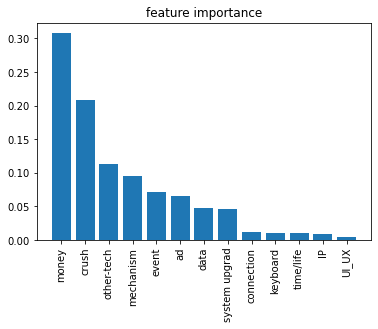

In [78]:
feature_importance(X_raw_app,y_app)

0.664598828928628


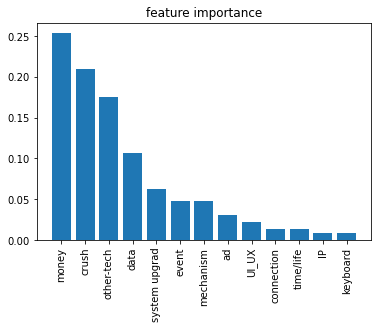

In [79]:
feature_importance(X_raw_goo,y_goo)

In [85]:
df_merge_apple[df_merge_apple['data']==0]

,userName,date,content,score,if_apple,if_useful,crush,data,keyboard,time/life,IP,system upgrad,connection,other-tech,money,UI_UX,event,mechanism,ad
94785,K.ElizabethMorgan,2020-12-13 11:16:34,play game got good fight sure think actual go ...,5,1,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
94786,MinnieMouse7794,2022-04-02 13:58:11,love game long say game bad get brand new woul...,5,1,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
94787,Nerd of EVERYTHING,2022-10-04 22:35:17,day addict cool earn sent keyboard use complai...,5,1,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
94788,Han Bolo,2020-11-05 20:52:47,live game wouldnt trade world like fish wish b...,5,1,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,-1.0,0.0,0.0,0.0,0.0
94789,amelia the great!,2022-03-01 21:15:38,big fan game think game like one big popular g...,5,1,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163653,jfsajk,2017-12-02 06:57:59,great,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
163654,ty lol ty,2022-09-26 07:38:26,fun,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
163655,pogdw,2022-09-20 21:43:42,fun,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
163656,arajuju,2022-08-03 12:04:10,love,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
